# Simple Linear Regression Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from scipy import stats
from sklearn import datasets
from IPython.display import display, HTML

In [2]:
auto_df=pd.read_csv("Data/auto.csv")

In [3]:
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


### removing missing values

In [4]:
auto_df=auto_df.drop(auto_df[auto_df.values == '?'].index)
auto_df = auto_df.reset_index()
auto_df.head()

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


### convert quantitative variables into numeric:

In [5]:
datatypes = {'quant': ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'],
             'qual': ['origin', 'name']}
quants = auto_df[datatypes['quant']].astype(np.float_)
auto_df = pd.concat([quants, auto_df[datatypes['qual']]], axis=1) 

# Linear regression from scratch:

In [6]:
intercept_const=pd.DataFrame({'intercept':np.ones(auto_df.shape[0])})
X=pd.concat([intercept_const,auto_df["horsepower"]],axis=1)
y=auto_df["mpg"]

In [7]:
def linear_model(X,y):
    XTX_inv=np.linalg.inv(np.dot(X.T,X))
    XTy=np.dot(X.T,y)
    beta=np.dot(XTX_inv,XTy)
    return beta
def predict(beta,X):
    return np.dot(X,beta)

In [8]:
coefficients=linear_model(X,y)

In [9]:
y_pred=predict(coefficients,X)

#### Calculation of summary of the model:

In [10]:
# Mean Squared Error:
MSE=np.sum(np.square(y_pred-y))/y.size

# Calculation of variance of beta for each variable:
Variance=MSE * (np.linalg.inv(X.T @ X).diagonal())

#Standard error:
standard_error=np.sqrt(Variance)

#t-stat:
t_stat=coefficients/standard_error

#p_value:
p_values=2*(1-stats.t.cdf(X.shape[0],np.abs(t_stat)))

#Reprentation:
results=pd.DataFrame({"features":X.columns,
                      "coefficients":coefficients,
                      "standard_error":standard_error,
                      "t_statistics":np.abs(t_stat),
                      "p_values":p_values})
results.set_index("features")

,coefficients,standard_error,t_statistics,p_values
features,,,,
intercept,39.935861,0.715666,55.802376,0.0
horsepower,-0.157845,0.006429,24.551848,0.0


# Calculation of all above things with stat model library:

In [11]:
X=auto_df["horsepower"]
X=sm.add_constant(X)
y=auto_df["mpg"]

results=sm.OLS(y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Wed, 06 Jul 2022   Prob (F-statistic):           7.03e-81
Time:                        20:40:44   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals?

In [12]:
# predicted mpg associated with a horsepower of 98
x_ex=np.array([1,98])
y_ex=predict(coefficients,x_ex)
print(str(np.round(y_ex,3)) + 'mpg')

24.467mpg


In [13]:
# 95% confidence interval for coefficients:
print(results.conf_int(alpha=0.05))

                    0          1
const       38.525212  41.346510
horsepower  -0.170517  -0.145172


In [14]:
#95% confidence interval of prediction of x_ex:
model_min=results.conf_int(alpha=0.05)[0]
model_max=results.conf_int(alpha=0.05)[1]

confidence_int=[predict(model_min,x_ex),predict(model_max,x_ex)]
print(confidence_int)

[21.814544959722653, 27.119609345302212]


### Plot the responce and the predictor

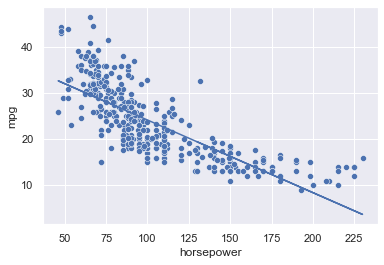

In [15]:
df=pd.concat([auto_df["horsepower"],auto_df["mpg"]],axis=1)
ax=sns.scatterplot(x='horsepower',y='mpg',data=df)
ax.plot(auto_df["horsepower"],y_pred);

## Diagonastic plot for the Least Square Fit:

In [16]:
def lm_stat(X,y,y_pred):
    try: 
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    #Residuals
    residuals=np.array(y-y_pred)
    
    #Hat_matrix:
    H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T
    
    #leverage:
    h_ii=H.diagonal()
    
    #Externalised studentised residual:
    
    # Estimate variance (externalised)
     # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    
     # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t,
                         'y_pred': y_pred})

In [17]:
X=pd.concat([auto_df["horsepower"]],axis=1)
intercept_const=pd.DataFrame({"intercept":np.ones(X.shape[0])})
X=np.array(pd.concat([X,intercept_const],axis=1))
y=auto_df["mpg"]

In [18]:
info=lm_stat(X,y,y_pred)
info.head()

,residual,leverage,studentised_residual,y_pred
0,-1.416046,0.003676,-0.287780,19.416046
1,1.108520,0.008876,0.224684,13.891480
2,1.740849,0.006130,0.353372,16.259151
3,-0.259151,0.006130,-0.052596,16.259151
4,-0.837598,0.004730,-0.170121,17.837598


#### Studentised residual plot:

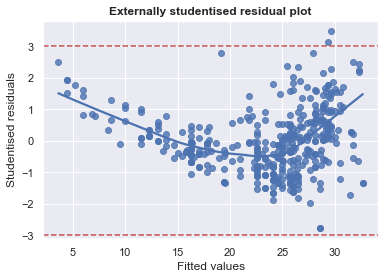

In [19]:
ax=sns.regplot(x=info["y_pred"],y=info["studentised_residual"],lowess=True)
plt.xlabel('Fitted values')
plt.ylabel('Studentised residuals')
plt.title('Externally studentised residual plot', fontweight='bold')
# Draw Hastie and Tibshirani's bounds for possible outliers
ax.axhline(y=3, color='r', linestyle='dashed')
ax.axhline(y=-3, color='r', linestyle='dashed');

#### Residual plot

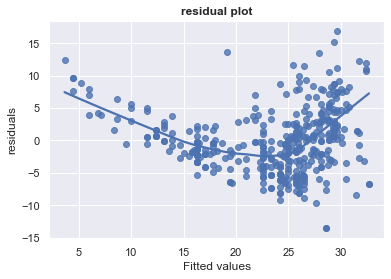

In [20]:
ax=sns.regplot(x=info["y_pred"],y=info["residual"],lowess=True)
plt.xlabel('Fitted values')
plt.ylabel('residuals')
plt.title('residual plot', fontweight='bold');

#### Leverage vs studentised residual plot

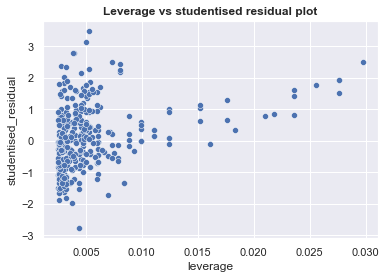

In [21]:
ax=sns.scatterplot(x=info["leverage"],y=info["studentised_residual"])
plt.xlabel('leverage')
plt.ylabel('studentised_residual')
plt.title('Leverage vs studentised residual plot', fontweight='bold');

#### Distribution of residuals

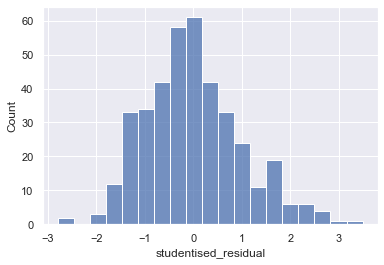

In [22]:
ax=sns.histplot(info["studentised_residual"]);

## Conclusion:

- **Non-Linearity:** The residual plot suggests that there is some linearity may present in the data.So better to try some non-linear model.
- **Heterosedacity:** Also there is non-constant variance of error term(heterosedacity) present in the data.
- **Outliers and leverage:** As Leverage vs studentised residual plot there are several outlier present in the data.
- **Distribution of residual:** Residuals are slightly non-normaly distributed

# Multiple Linear Regression:

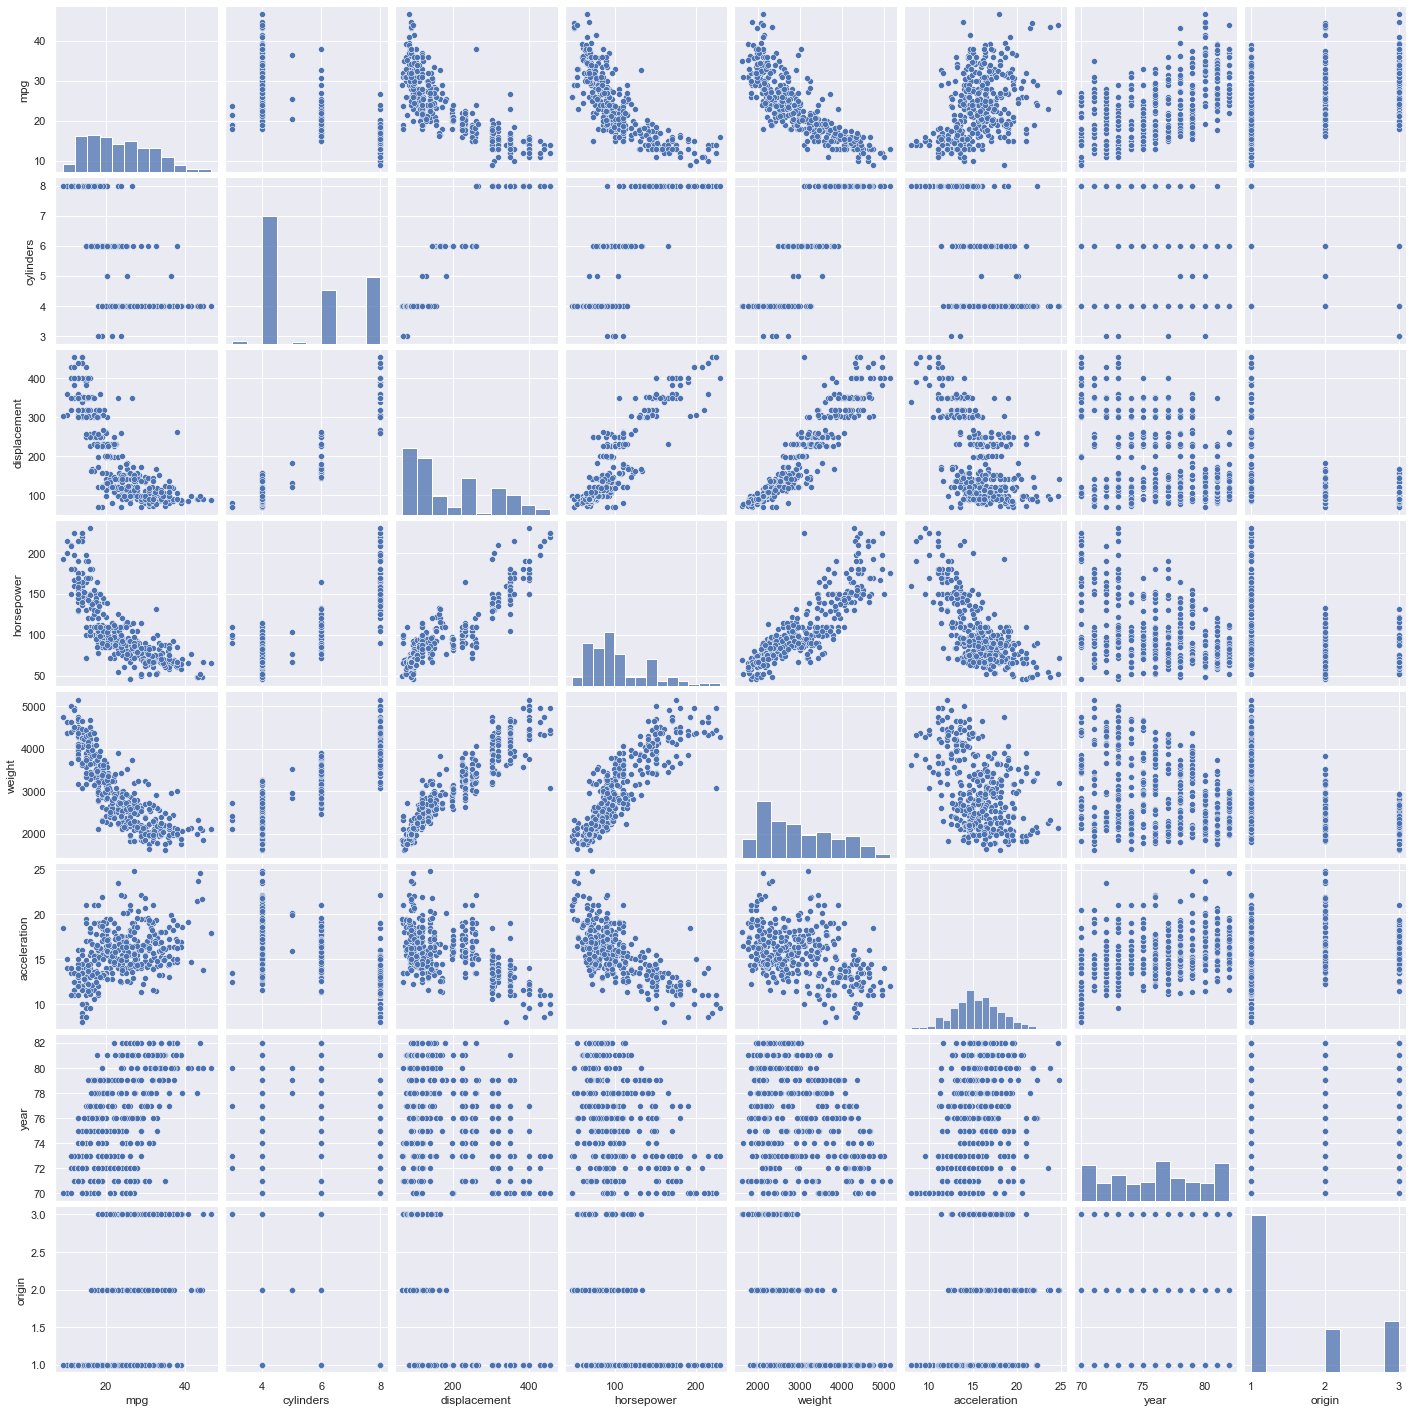

In [23]:
sns.pairplot(auto_df);

### Matrix of correlation:

In [24]:
corr_matrix=auto_df.corr().abs()

In [25]:
corr_matrix

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,0.777618,0.805127,0.778427,0.832244,0.423329,0.580541,0.565209
cylinders,0.777618,1.000000,0.950823,0.842983,0.897527,0.504683,0.345647,0.568932
displacement,0.805127,0.950823,1.000000,0.897257,0.932994,0.543800,0.369855,0.614535
horsepower,0.778427,0.842983,0.897257,1.000000,0.864538,0.689196,0.416361,0.455171
weight,0.832244,0.897527,0.932994,0.864538,1.000000,0.416839,0.309120,0.585005
acceleration,0.423329,0.504683,0.543800,0.689196,0.416839,1.000000,0.290316,0.212746
year,0.580541,0.345647,0.369855,0.416361,0.309120,0.290316,1.000000,0.181528
origin,0.565209,0.568932,0.614535,0.455171,0.585005,0.212746,0.181528,1.000000


In [26]:
auto_df.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')

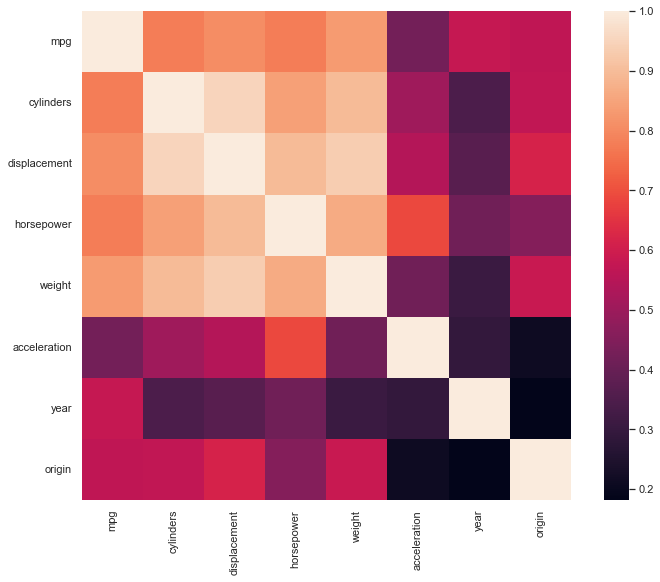

In [27]:
corr_matrix = auto_df.corr().abs()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=1, square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0);

In [28]:
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1,ford torino


In [29]:
X=auto_df.drop(columns=["mpg","name"])

In [30]:
X=sm.add_constant(X)

C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [31]:
X.head()

,const,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,1.0,8.0,307.0,130.0,3504.0,12.0,70.0,1
1,1.0,8.0,350.0,165.0,3693.0,11.5,70.0,1
2,1.0,8.0,318.0,150.0,3436.0,11.0,70.0,1
3,1.0,8.0,304.0,150.0,3433.0,12.0,70.0,1
4,1.0,8.0,302.0,140.0,3449.0,10.5,70.0,1


In [32]:
y=auto_df["mpg"]

In [33]:
model=sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          2.04e-139
Time:                        20:41:29   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.644     -3.707   

#### Q: Is there any relationship between the predictors and responce?
Ans: The F-stat suggest that there is relationship between the predictors and the responce.

#### Q: Which predictors appear to have a statistically significant relationship to the response?

In [34]:
model.pvalues[model.pvalues<0.05].sort_values()

year            3.055983e-39
weight          7.874953e-21
origin          4.665681e-07
const           2.401841e-04
displacement    8.444649e-03
dtype: float64

#### Q: What does the coefficient for the year variable suggest?
Ans: Year variable coefficient suggests that there is a positive relationship between year and mpg.Hence in recent years more fuel efficent veichles are likely to be produced.On average fuel efficiency are likely to be increased by 0.75mpg/year.

# Diagonastic Plots:

In [35]:
X=np.array(X)

In [36]:
y_pred=np.array(model.predict(X))
info=lm_stat(X,y,y_pred)

### Studentised Residual Plot:

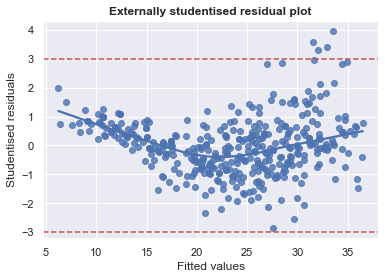

In [37]:
ax=sns.regplot(x=info["y_pred"],y=info["studentised_residual"],lowess=True)
plt.xlabel('Fitted values')
plt.ylabel('Studentised residuals')
plt.title('Externally studentised residual plot', fontweight='bold')
# Draw Hastie and Tibshirani's bounds for possible outliers
ax.axhline(y=3, color='r', linestyle='dashed')
ax.axhline(y=-3, color='r', linestyle='dashed');

### Leverage vs Studentised Residual:

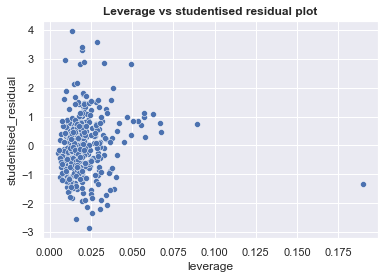

In [38]:
ax=sns.scatterplot(x=info["leverage"],y=info["studentised_residual"])
plt.xlabel('leverage')
plt.ylabel('studentised_residual')
plt.title('Leverage vs studentised residual plot', fontweight='bold');

### Distribution of residuals:

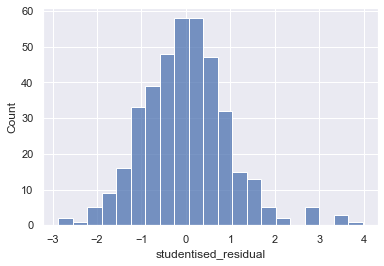

In [39]:
ax=sns.histplot(info["studentised_residual"]);

# Conclusion:

##### linearity:
The u-shaped pattern in the top-left residual plot suggests that there a non-linear relationship that our model is unable to account for. The bottom left Scale-Location plot suggests that a square-root transform reduces the non-linearity of this relationship allowing our model to achieve an improved fit.

##### Heteroscedasticity:
 A conical pattern is apparent in the top-left plot suggesting that variance of residuals increases with response. The bottom left plot suggests that a square-root transform helps to mitigate this effect.
 
 ##### Outlier:
The top-left plot suggests that there are five potential outliers towards the high end of our predicted responses. The bottom-right plot suggests that these outliers have low leverage, and so probably don't have a overly dispraportionate effect on our model.

##### Leverage:
The bottom right plot reveals one point with particularly high leverage, although with a value around -1.2 this point isn't an outlier in terms of studentised residuals.

##### Normality:
The top-right plot shows a normal distribution except for high value residuals. This suggests that the model under-estimates mpg for a larger number of observations than we might expect assuming a normal distribution.